In [1]:
from biasbalancer.balancer import BiasBalancer
from biasbalancer.get_compas_data import get_compas_data

# BiasBalancer Tutorial
*Authors:* Caroline Amalie Fuglsang-Damgaard, Elisabeth Zinck

The following notebook is a tutorial of the toolkit `BiasBalancer`, which is a toolkit for analysing potential unfairness in predictions from a binary classification model.

The BiasBalancer class is a 3-level toolkit for analysing and understanding how much unfairness is present in predictions from a given predictive algorithm. It analyses the unfairness by subgroups dictated by a sensitive attribute such as sex or race. The three levels of BiasBalancer each returns a visualization and the data behind. Each level nuances the analysis and aids the user in obtaining a deeper understanding of the predictions.

For further details about BiasBalancer, we refer to the [BiasBalancer documentation](https://elisabethzinck.github.io/Fairness-oriented-interpretability-of-predictive-algorithms/html/biasbalancer.html).

## Data 
In this tutorial, we will use the canonical COMPAS dataset to demonstrate the use of BiasBalancer. The COMPAS dataset was analyzed in ProPublica's [article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) about machine bias in criminal sentencing. 

The COMPAS dataset contains predictions from the COMPAS algorithm, which assigns a `decile_score` between 1 and 10 to a criminal. A score above 5 means that the criminal is considered to have medium(6-8) or high(9-10) risk of comitting another crime (also called recidivating) within two years. The prediction, `pred`, of the binary classification of the $\text{i}^{\text{th}}$ criminal is given by
$$
\text{pred}_i = \begin{cases}
    0 &\text{decile score}_i <= 5\\
    1 &\text{decile score}_i > 5
\end{cases}.
$$
The target variable, `two_year_recid`, is binary and denotes whether the individual actually recidivated within two years, 1 meaning that they did recidivate. The COMPAS dataset will be analyzed wrt. discrimination based on the sensitive attribute `race`. 

A pre-processed version of the dataset can be loaded using the function `get_compas_data`, which was imported from the `biasbalancer` module in the beginning of this notebook. 

In [2]:
compas = get_compas_data(normalize_decile_scores = True)

We set `normalize_decile_scores` to True, which means the scores are divided with 10 such that they can be used as prediction scores. The dataset looks in the following way: 

In [3]:
compas.head(5)

,id,sex,age,age_cat,race,decile_score,score_text,two_year_recid,pred
1,3,Male,34,25 - 45,African-American,0.3,Low,1,False
2,4,Male,24,Less than 25,African-American,0.4,Low,1,False
6,8,Male,41,25 - 45,Caucasian,0.6,Medium,1,True
8,10,Female,39,25 - 45,Caucasian,0.1,Low,0,False
10,14,Male,27,25 - 45,Caucasian,0.4,Low,0,False


## Initialization of Class
The following section shows how the BiasBalancer class is initialized. To initialize the class one must specify: 

* `data`: DataFrame containing data used for evaluation
* `y_name`: Name of target variable
* `y_hat_name`: Name of binary output variable
* `r_name`: Name of variable containing scores (scores must be within [0,1])
* `a_name`: Name of sensitive variable 
* `w_fp`: False positive weight
* `model_name`: Name of the model or dataset used. Is used for plot titles. (Optional)
 

The false positive weight $w_{FP} \in [0,1]$ balances the severity of receiving a false positive vs. a false negative. Higher false positive weights means that a false positive is considered to be more severe than a false negative. Because it can have severe negative consequences to be classified as a possible recidivist, it is suitable to choose a high false positive weight when analyzing the COMPAS dataset, such as $w_{FP} = 0.9$. The class `BiasBalancer` was imported in the first cell of the notebook and is initialized below :

In [4]:
compas_w_fp = 0.9
fair_compas = BiasBalancer(
    data = compas,
    y_name = "two_year_recid", 
    y_hat_name = "pred", 
    a_name = "race", 
    r_name = "decile_score",
    w_fp = compas_w_fp,
    model_name='COMPAS Decile Scores')

## Level 1 - Single Unfairness Measure

The first level should be used to get a quick overview of whether there is unfairness present in the predictions and how much. For this, the maximum relative difference in percent between the sensitive groups' weighted misclassification rates (WMR) is used.

The *weighted misclassification rate* of sensitive group $a$ is defined as
$$
    \textit{WMR}_a = c(w_{FP})\cdot\frac{w_{FP} FP_a + (1-w_{FP})FN_a}{n_a},
$$
where $FP_a$ is the number of false positives in group $a$, $FN_a$ is the number of false negatives in group $a$, $n_a$ is the number of observations belonging to group $a$, and $w_{FP}$ is the false positive weight indicating the severity of a false positive. $c(w_{FP})$ is a normalization constant ensuring that $\textit{WMR} \in [0,1]$. 

The *weighted misclassification quotient* (WMQ) for group $a$ is the percent increase in the weighted misclassification rate relative to the group with the minimum rate:
$$
    \textit{WMQ}_a = \frac{\textit{WMR}_a - \textit{WMR}_{min}}{\textit{WMR}_{min}+\varepsilon}\cdot100\%.
$$
where the minimum rate is defined as $\textit{WMR}_{min} = \min_{a \in A} WMR_a$ and $\varepsilon$ is a small number added to the denominator to ensure the expression is well-defined if $\textit{WMR}_{min}=0$. The overall unfairness present in the model is measured by the maximum weighted misclassification quotient across the sensitive groups. 

The results from the first level of BiasBalancer is accessed using the `level_1()` method:

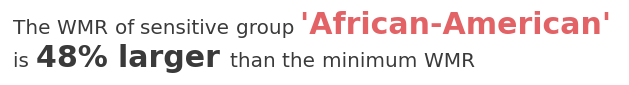

In [5]:
level1_output_data = fair_compas.level_1()

In [6]:
level1_output_data

,grp,n,WMR,WMQ
0,African-American,2682,0.252796,47.877821
1,Caucasian,1829,0.170950,0.000000


From the illustration above it is seen that African-Americans see a 48% larger weighted misclassification rate (WMR) compared to the group with the smallest *WMR*, which suggests that the predictions by the COMPAS algorithm disfavor African-Americans. The illustration always shows the largest weighted misclassification quotient, and should be seen as a red flag highlighting the most disfavored group in terms of the *WMR*. 

The table shows that Caucasians have the smallest *WMR* and therefore a weighted misclassification quotient of 0%. The table includes one row for each sensitive group. 

The weighted classification quotient can be used to compare the degree of unfairness between different models. 

## Level 2 - Overview of Unfairness

#### New: 
Second level of BiasBalancer creates a visual overview of the unfairness in the predictions. The overview consists of three elements structured in a visualization and three data frames. It consists of absolute rates, relative rates and an unfairness barometer. 
        
The absolute rates visualized are 

* False Positive Rate $\left(FPR=\frac{FP}{N}\right)$
* False Negative Rate $\left(FNR=\frac{FN}{P}\right)$
* False Discovery Rate $\left(FDR=\frac{FP}{PP}\right)$
* False Omission Rate $\left(FDR=\frac{FN}{PN}\right)$

where *FP* are false positives, *FN* are false negatives, *N* are negatives, *P* are positves, *PN* are predicted negatives and *PP* are predicted positives. The relative rates are computed for each group.

The relative rates for group $a$ are computed by
$$
\begin{align}
RR_a(r) &= \frac{r_{a} - r_{min}}{r_{min}+\varepsilon}\cdot100\% \\
r_{min} &= \min_{a\in A} r_a,
\end{align}
$$

which is computed for rates $r \in \{\textit{FPR},~\textit{FNR},~\textit{FDR},~\textit{FOR},~\textit{WMR}\}$. Again, a small $\varepsilon$ is added to the denominator to ensure the relative rate is well-defined if $\textit{r}_{min}=0$.

The unfairness barometer indicates the level of unfairness present in the predictions according to different fairness criteria. The fairness criteria are summarized in the overview table below. 

|Fairness Criterion |Enforces  |
|:----------------:|:-:|
|Independence  | $$\frac{PP_a}{N_a} = \frac{PP_b}{N_b}$$    |
|Sufficiency                      |$FOR_a = FOR_b$ and $FDR_a = FDR_b$|
|Predictive Parity $\bullet$|$FDR_a = FDR_b$                         |
|Separation                       |$FPR_a = FPR_b$ and $FNR_a = FNR_b$|
|FPR-balance $\star$        |$FPR_a = FPR_b$                         |
|Equal Opportunity $\star$  |$FNR_a = FNR_b$                          |

The quantity depicted in the unfairness barometer is called the *mean maximum relative rate (MMRR)*. Informally, this is the maximum relative rate across sensitive subgroups, if the criterion only depends on one rate. If the criterion depends on several rates it shows the mean of the different rate components instead.
Below the second level visualization is shown:

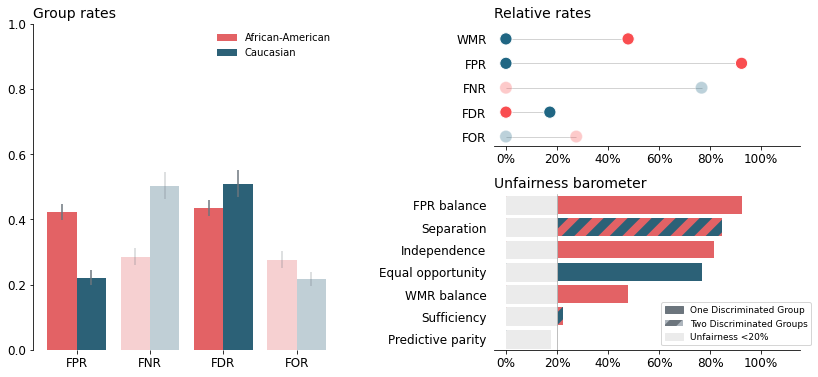

In [7]:
rates, relative_rates, barometer = fair_compas.level_2()

The plot shows that African-Americans have almost twice as high false positive rates as Caucasians. This results in the unfairness barometer being the largest for FPR balance and separation since these fairness criteria are based on the false positive rate. 

The false negative rate is much higher for Caucasians than for African-Americans, which results in large violations of the criteria Equal opportunity and separation. 

Since $w_{FP} = 0.9$, a false positive prediction is considered to be more severe than a false negative. The WMR balance takes this trade-off into account, and hence deem African-Americans to be more disfavored than Caucasians. 

Finally, the independence criterion is violated, which means that African-Americans have a higher rate of receiving the unfavorable prediction. This means that a larger proportion of African-Americans are predicted to have a high risk of recidivating. 

The data shown in the plot is also returned: 

In [8]:
rates.head()

,rate,grp,rate_val,rate_val_lwr,rate_val_upr
0,FDR,African-American,0.434282,0.409198,0.459707
1,FDR,Caucasian,0.509025,0.467478,0.550448
2,FNR,African-American,0.285103,0.259949,0.311665
3,FNR,Caucasian,0.503650,0.461909,0.545340
4,FOR,African-American,0.276119,0.251628,0.302032


In [9]:
relative_rates.head()

,rate,grp,rate_val,relative_rate
0,FDR,African-American,0.434282,0.000000
1,FDR,Caucasian,0.509025,17.210811
2,FNR,African-American,0.285103,0.000000
3,FNR,Caucasian,0.503650,76.655488
4,FOR,African-American,0.276119,27.555159


In [10]:
barometer

,criterion,relative_rate,discriminated_grp
1,FPR balance,92.323421,[African-American]
4,Separation,84.489454,"[Caucasian, African-American]"
2,Independence,81.690209,[African-American]
0,Equal opportunity,76.655488,[Caucasian]
6,WMR balance,47.877821,[African-American]
5,Sufficiency,22.382985,"[Caucasian, African-American]"
3,Predictive parity,17.210811,[Caucasian]


## Level 3 - Analysis of Unfairness Sources

The third, and last, level contains methods that can be used for analysing the sources of the unfairness more in depth. The output from level 2 is useful for determining which analyses should be carried out in the third level. The available methods in level 3 are: 
- `w_fp_influence`: Shows how different settings of `w_fp` influence the weighted misclassification quotients. 
- `roc_curves`: ROC curves for each sensitive group. Suitable if the unfairness barometer shows high disparities in *separation*, *FPR balance* or *Equal opportunity*. 
- `calibration`: Calibration curve for each sensitive group. Suitable if the unfairness barometer shows high disparities in *sufficiency* or *predictive parity*.
- `confusion_matrix`: Displays a confusion matrix for each sensitive group. Especially useful when group sizes are small. 
- `independence_check`: Displays the fraction of individuals predicted to most unfavored outcome. Suitable if there are high disparities in *independence*. 

In this example using COMPAS, independence and separation shows the biggest differences between groups, so the methods `roc_curves` and `independence_check` are used. The methods can be accessed using the method `level_3()` and specifying the argument `method`. 

### ROC Curve Analysis
The ROC curves for the two groups are similar, but the cut-off of `decile_score = 0.5` lies very differently on the curves. This results in higher true positive rate (equivalently lower false negative rate) and a higher false positive rate for African-Americans. 

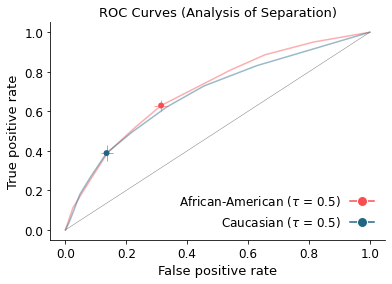

In [11]:
roc = fair_compas.level_3(method = 'roc_curves')

### Independence Check Analysis
The plot shows that the independence criterion was violated because African-Americans are predicted to recidivate at a much higher rate than Caucasians. The errors bars (showing 95% Wilson confidence intervals) show that this difference cannot be attributed to random fluctuations. 

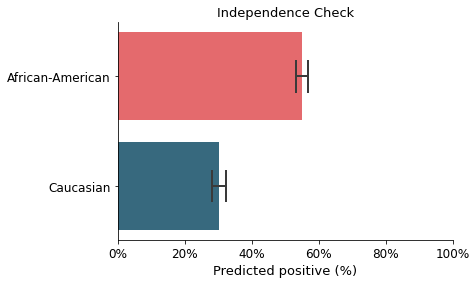

In [12]:
independence = fair_compas.level_3(method = 'independence_check')

## Conclusion
The above analysis suggests that overall African-Americans could be discriminated by the predictions because they receive more unfavorable predictions than Caucasians. This is because African-Americans more often are predicted to recidivate, including when the prediction was correct, and more worringly also when the prediction was incorrect. The more in depth analyses showed that the threshold of `decile_score`=5 seemed to inflate the number of unfavorable predictions for African-Americans. 

This notebook shows how the three levels in `BiasBalancer` can be used to gain a more nuanced analysis of the unfairness in the predictions. The results from level 1 suggested that further unfairness analysis was necessary, and the results from level 2 lead to the more in depth analyses `independence_check` and `roc_curves`. For completeness, the output from the remaining available analysis methods in level 3 are shown in the next section. 

## The remaining plots in level 3

### False positive weight influence
The plots shows how the weighted misclassification quotient changes as the false positive weight, $w_{FP}$, changes. Increasing the false positive weight, indicating that false positives are more severe, increases the weighted misclassification quotient for African-Americans. If it were worse to be predicted to have a low risk of recidivating, then the weighted misclassification quotient suggests that Caucasians could be discriminated slightly by the algorithm. 

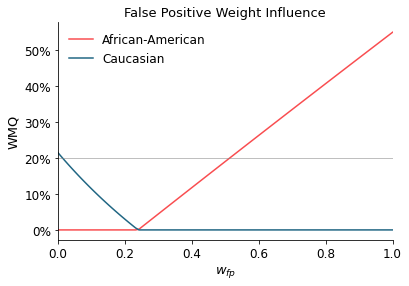

In [13]:
fair_compas.level_3(method = 'w_fp_influence', output_table = False)

### Calibration analysis
The plot shows how well the predicted probabilities align with true probabilities (calculated as the proportion of true outcomes in the bin). The two groups behave similarly in this plots, which is also why only small sufficiency values were seen in the unfairness barometer. 

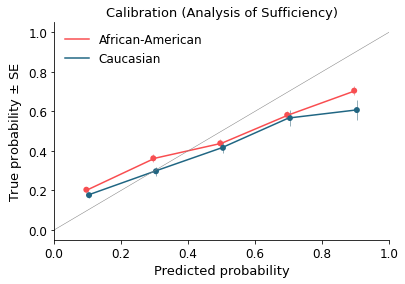

In [14]:
cal = fair_compas.level_3(method = 'calibration', n_bins = 5)

### Confusion matrices 
The plot shows the confusion matrix by sensitive group. The percentages denote the percentage of the individuals in the sensitive group who received the specified combination of prediction and outcome. In the marginal labels we see how there are more actual positives and predicted positives among African-Americans. This different marginal distribution of outcomes for African-Americans could be a factor in why the number of false positives is also large in the group. 

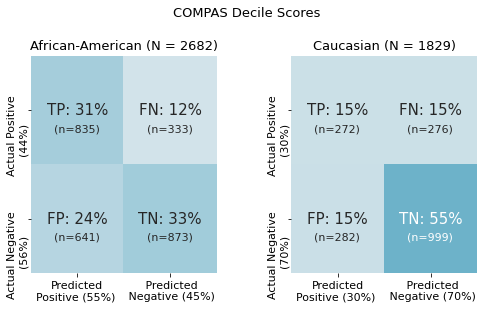

In [15]:
confusion = fair_compas.level_3(method = 'confusion_matrix', **{'cm_print_n': True})